In [11]:
import os, sys 
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import uniform_filter

import psutil
import torch
import torch.nn.functional as F

def memory_check():
    """
    Print the current memory usage.
    """
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 * 1024)  # Convert to MB
    print(f"Memory usage: {mem:.2f} MB")

def load_complex_data(file_path):
    """
    Load TIFF file containing real and imaginary parts in the last dimension (HxWx2) and combine them into complex data.

    Parameters:
        file_path (str): Path to the TIFF file.

    Returns:
        np.ndarray: Complex-valued 2D array.
    """
    data = tiff.imread(file_path)
    print(f"{file_path} loaded. shape: {data.shape}")

    if data.shape[-1] != 2:
        raise ValueError("Expected input data with last dimension as 2 for real and imaginary parts.")

    real_part = data[:, :, 0]
    imag_part = data[:, :, 1]

    return real_part + 1j * imag_part

from scipy.ndimage import uniform_filter
import numpy as np

def compute_restricted_coherence_matrix(HH, HV, window_size, block_size):
    """
    Compute the restricted coherence matrix for dual-pol data (HH, HV).

    Parameters:
        HH (np.ndarray): HH polarization complex data.
        HV (np.ndarray): HV polarization complex data.
        window_size (int): Size of the averaging window.
        block_size (int): Size of the processing blocks.

    Returns:
        np.ndarray: Coherence matrix with shape (2, 2, H, W).
    """
    H, W = HH.shape
    coherence_matrix = np.zeros((2, 2, H, W), dtype=np.complex64)
    pad_size = window_size // 2

    # Pad the input data to handle edge effects
    HH_padded = np.pad(HH, ((pad_size, pad_size), (pad_size, pad_size)), mode='reflect')
    HV_padded = np.pad(HV, ((pad_size, pad_size), (pad_size, pad_size)), mode='reflect')

    for row_start in range(0, H, block_size):
        for col_start in range(0, W, block_size):
            row_end = min(row_start + block_size, H)
            col_end = min(col_start + block_size, W)

            padded_row_start = row_start + pad_size
            padded_col_start = col_start + pad_size
            padded_row_end = row_end + pad_size
            padded_col_end = col_end + pad_size

            # Extract the block with padding
            HH_block = HH_padded[padded_row_start - pad_size:padded_row_end + pad_size,
                                 padded_col_start - pad_size:padded_col_end + pad_size]
            HV_block = HV_padded[padded_row_start - pad_size:padded_row_end + pad_size,
                                 padded_col_start - pad_size:padded_col_end + pad_size]

            # Compute coherence matrix components with spatial averaging
            T11 = uniform_filter(np.abs(HH_block)**2, size=window_size)[pad_size:-pad_size, pad_size:-pad_size]
            T22 = uniform_filter(np.abs(HV_block)**2, size=window_size)[pad_size:-pad_size, pad_size:-pad_size]
            T12_real = uniform_filter((HH_block * np.conj(HV_block)).real, size=window_size)[pad_size:-pad_size, pad_size:-pad_size]
            T12_imag = uniform_filter((HH_block * np.conj(HV_block)).imag, size=window_size)[pad_size:-pad_size, pad_size:-pad_size]

            # Populate the coherence matrix
            coherence_matrix[0, 0, row_start:row_end, col_start:col_end] = T11
            coherence_matrix[1, 1, row_start:row_end, col_start:col_end] = T22
            coherence_matrix[0, 1, row_start:row_end, col_start:col_end] = T12_real + 1j * T12_imag
            coherence_matrix[1, 0, row_start:row_end, col_start:col_end] = T12_real - 1j * T12_imag

    print("Restricted coherence matrix computed.")
    return coherence_matrix


def restricted_alpha_entropy_decomposition(HH, HV, window_size=3, block_size=250):
    """
    Perform Restricted Alpha-Entropy Decomposition using the coherence matrix.

    Parameters:
        coherence_matrix (np.ndarray): Coherence matrix with shape (2, 2, H, W).
        window_size (int): Size of the averaging window for the coherence matrix.
        block_size (int): Size of the processing blocks.

    Returns:
        tuple: Entropy (H) and Alpha angle (α).
    """
    coherence_matrix = compute_restricted_coherence_matrix(HH, HV, window_size, block_size)

    H, W = coherence_matrix.shape[2:]
    entropy = np.zeros((H, W))
    alpha = np.zeros((H, W))
    Z = np.zeros((H, W))

    for i in range(H):
        print(f"Row: {i}")
        memory_check()
        for j in range(W):
            local_matrix = coherence_matrix[:, :, i, j]

            # Eigenvalue decomposition
            eigvals = np.linalg.eigvalsh(local_matrix)
            eigvals = np.maximum(eigvals, 1e-8)  # Avoid zeros or negative values
            eigvals_sum = np.sum(eigvals)
            p = eigvals / eigvals_sum

            # Compute entropy
            entropy[i, j] = -np.sum(p * np.log2(p))

            # Compute alpha angle
            alpha[i, j] = np.arctan(np.sqrt(eigvals[1] / eigvals[0])) * (180 / np.pi)

                        # Land type classification
            if entropy[i, j] >= 0.9 and alpha[i, j] >= 55:
                Z[i, j] = 1  # Z1: Forest and canopy structures
            elif entropy[i, j] >= 0.9 and alpha[i, j] >= 42:
                Z[i, j] = 2  # Z2: Cloud
            elif entropy[i, j] >= 0.9 and alpha[i, j] >= 40:
                Z[i, j] = 3  # Z3: Not possible region
            elif entropy[i, j] >= 0.5 and alpha[i, j] >= 50:
                Z[i, j] = 4  # Z4: Forestry or double bounce
            elif entropy[i, j] >= 0.5 and alpha[i, j] >= 40:
                Z[i, j] = 5  # Z5: Vegetation
            elif entropy[i, j] >= 0.5 and alpha[i, j] < 40:
                Z[i, j] = 6  # Z6: Random surface propagation
            elif entropy[i, j] < 0.5 and alpha[i, j] >= 48:
                Z[i, j] = 7  # Z7: Dihedral scatterer
            elif entropy[i, j] < 0.5 and alpha[i, j] >= 42:
                Z[i, j] = 8  # Z8: Dipole
            elif entropy[i, j] < 0.5 and alpha[i, j] < 42:
                Z[i, j] = 9  # Z9: X-Bragg surface
            else:
                ValueError("alpha / entropy values are not valid")

    print("Restricted alpha-entropy decomposition completed.")
    return entropy, alpha, Z


def compute_pauli_vector(HH, HV, VH, VV):
    """
    Compute the Pauli vector representation using the provided polarimetric channels.

    Parameters:
        HH (np.ndarray): HH polarization complex data.
        HV (np.ndarray): HV polarization complex data.
        VH (np.ndarray): VH polarization complex data.
        VV (np.ndarray): VV polarization complex data.

    Returns:
        np.ndarray: 3xHxW Pauli vector.
    """
    # Pauli vector components
    pauli_1 = (HH + VV) / np.sqrt(2)
    pauli_2 = (HH - VV) / np.sqrt(2)
    pauli_3 = (HV + VH) / np.sqrt(2)

    print("Pauli vector computed")
    
    return np.stack([pauli_1, pauli_2, pauli_3], axis=0)

def compute_coherence_matrix(pauli_vector, window_size, block_size):
    """
    Compute the coherence matrix by processing block-by-block with neighborhood averaging.

    Parameters:
        pauli_vector (np.ndarray): 3xHxW Pauli vector.
        window_size (int): Size of the averaging window.
        block_size (int): Size of the processing blocks.

    Returns:
        np.ndarray: Coherence matrix with shape (3, 3, H, W).
    """
    H, W = pauli_vector.shape[1:]
    coherence_matrix = np.zeros((3, 3, H, W), dtype=np.complex64)
    pad_size = window_size // 2

    # Pad the Pauli vector to handle edge effects
    padded_pauli_vector = np.pad(pauli_vector, ((0, 0), (pad_size, pad_size), (pad_size, pad_size)), mode='reflect')

    for row_start in range(0, H, block_size):
        for col_start in range(0, W, block_size):
            row_end = min(row_start + block_size, H)
            col_end = min(col_start + block_size, W)

            # Add padding to the block for neighborhood filtering
            padded_row_start = row_start + pad_size
            padded_col_start = col_start + pad_size
            padded_row_end = row_end + pad_size
            padded_col_end = col_end + pad_size

            block = padded_pauli_vector[:, padded_row_start - pad_size:padded_row_end + pad_size,
                                        padded_col_start - pad_size:padded_col_end + pad_size]

            block_coherence = np.zeros((3, 3, block.shape[1] - 2 * pad_size, block.shape[2] - 2 * pad_size), dtype=np.complex64)

            # Compute block coherence matrix
            for i in range(3):
                for j in range(3):
                    block_coherence_full = block[i] * np.conj(block[j])

                    # Apply neighborhood averaging
                    block_coherence_avg = uniform_filter(block_coherence_full.real, size=window_size) + \
                                          1j * uniform_filter(block_coherence_full.imag, size=window_size)

                    # Trim the padding
                    block_coherence[i, j] = block_coherence_avg[pad_size:-pad_size, pad_size:-pad_size]

            # Assign back to the global coherence matrix
            coherence_matrix[:, :, row_start:row_end, col_start:col_end] = block_coherence

    print("Coherence_matrix computed")

    return coherence_matrix

def cloude_pottier_decomposition(pauli_vector, reference_vector, window_size=3, block_size=250):
    """
    Perform Cloude-Pottier decomposition to compute entropy, alpha angle, and classify land types.

    Parameters:
        pauli_vector (np.ndarray): 3xHxW Pauli vector.
        window_size (int): Size of the averaging window for the coherence matrix.
        block_size (int): Size of the processing blocks.

    Returns:
        tuple: Entropy (H), Alpha angle (alpha), and land type classification (Z).
    """
    H, W = pauli_vector.shape[1:]
    coherence_matrix = compute_coherence_matrix(pauli_vector, window_size, block_size)

    entropy = np.zeros((H, W))
    alpha = np.zeros((H, W))
    Z = np.zeros((H, W), dtype=np.uint8)

    # reference_vector = np.array([0, 0, 1], dtype=np.complex64)

    for i in range(H):
        print(f"Row: {i}")
        memory_check()
        for j in range(W):
            local_matrix = coherence_matrix[:, :, i, j]

            # Eigenvalue decomposition
            eigvals, eigvecs = np.linalg.eigh(local_matrix)
            eigvals = np.abs(eigvals)
            eigvals /= np.sum(eigvals)

            # Calculate entropy and alpha
            entropy[i, j] = -np.sum(eigvals * np.log(eigvals + 1e-10))

            # #Compute the mean alpha
            
            angles = np.arccos(np.clip(np.abs(np.dot(eigvecs.T, reference_vector)), 0, 1))
            angles_degrees = angles * (180 / np.pi)
            alpha[i, j] = np.sum(eigvals * angles_degrees)

            # angles = np.arccos(np.clip(np.abs(eigvecs[0, :]), 0, 1))  # Angles with reference [1, 0, 0] by default
            # angles_degrees = angles * (180 / np.pi)
            # alpha[i, j] = np.sum(eigvals * angles_degrees)

            # Land type classification
            if entropy[i, j] >= 0.9 and alpha[i, j] >= 55:
                Z[i, j] = 1  # Z1: Forest and canopy structures
            elif entropy[i, j] >= 0.9 and alpha[i, j] >= 42:
                Z[i, j] = 2  # Z2: Cloud
            elif entropy[i, j] >= 0.9 and alpha[i, j] >= 40:
                Z[i, j] = 3  # Z3: Not possible region
            elif entropy[i, j] >= 0.5 and alpha[i, j] >= 50:
                Z[i, j] = 4  # Z4: Forestry or double bounce
            elif entropy[i, j] >= 0.5 and alpha[i, j] >= 40:
                Z[i, j] = 5  # Z5: Vegetation
            elif entropy[i, j] >= 0.5 and alpha[i, j] < 40:
                Z[i, j] = 6  # Z6: Random surface propagation
            elif entropy[i, j] < 0.5 and alpha[i, j] >= 48:
                Z[i, j] = 7  # Z7: Dihedral scatterer
            elif entropy[i, j] < 0.5 and alpha[i, j] >= 42:
                Z[i, j] = 8  # Z8: Dipole
            elif entropy[i, j] < 0.5 and alpha[i, j] < 42:
                Z[i, j] = 9  # Z9: X-Bragg surface
            else:
                ValueError("alpha / entropy values are not valid")

    print("cloude_pottier_decomposition")

    return entropy, alpha, Z


def save_as_tiff(output_path, data):
    """
    Save a complex-valued 2D array as a multi-band TIFF file.

    Parameters:
        output_path (str): Path to save the TIFF file.
        data (np.ndarray): Data to save (supports real, complex, or multi-band).
        reference_file (str): Path to a reference TIFF file for shape and metadata.

    Returns:
        None
    """

    tiff.imwrite(output_path, data.astype(np.float32), dtype=np.float32)

def plot_intensity_and_angle(data, title_prefix):
    """
    Plot the intensity and angle of a complex dataset.

    Parameters:
        data (np.ndarray): Complex-valued 2D array.
        title_prefix (str): Prefix for the plot titles.

    Returns:
        None
    """
    intensity = np.abs(data)
    angle = np.angle(data)

    lower = np.percentile(intensity, 2)
    upper = np.percentile(intensity, 98)

    plt.figure(figsize=(12, 6))

    # Plot intensity
    plt.subplot(1, 2, 1)
    plt.imshow(intensity, cmap="gray", vmin=lower, vmax=upper)
    plt.title(f"{title_prefix} Intensity")
    plt.colorbar()

    # Plot angle
    plt.subplot(1, 2, 2)
    plt.imshow(angle, cmap="hsv")
    plt.title(f"{title_prefix} Angle")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


def plot_land_classification(Z):
    """
    Plot the land type classification with labeled regions and percentages.

    Parameters:
        Z (np.ndarray): Land type classification map.

    Returns:
        None
    """
    # Define a colormap and labels for the land types
    cmap = plt.cm.get_cmap('tab10', 9)
    labels = [
        "Z1: Forest and canopy structures",
        "Z2: Cloud",
        "Z3: Not possible region",
        "Z4: Forestry or double bounce",
        "Z5: Vegetation",
        "Z6: Random surface propagation",
        "Z7: Dihedral scatterer",
        "Z8: Dipole",
        "Z9: X-Bragg surface"
    ]

    # Calculate the percentage of each land type
    unique, counts = np.unique(Z, return_counts=True)
    total_pixels = Z.size
    percentages = {value: (count / total_pixels) * 100 for value, count in zip(unique, counts)}

    # Update labels to include percentages
    labels_with_percentages = [
        f"{label} ({percentages.get(i, 0):.2f}%)"
        for i, label in enumerate(labels, start=1)
    ]

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.imshow(Z, cmap=cmap, vmin=1, vmax=9)
    plt.colorbar(ticks=np.arange(1, 10), label="Land Type")

    # Add labels as text
    for i, label in enumerate(labels_with_percentages, start=1):
        plt.text(0, -i * 0.05, label, fontsize=10, transform=plt.gca().transAxes)

    plt.title("Land Type Classification")
    plt.axis("off")
    plt.show()

def perform_and_plot_land_classification(entropy, alpha, Z):
    """
    Plot the land type classification with labeled regions and a 2D density map of entropy and alpha.

    Parameters:
        entropy (np.ndarray): 2D array of entropy values.
        alpha (np.ndarray): 2D array of alpha values.

    Returns:
        None
    """
    # Ensure entropy and alpha have the same shape
    assert entropy.shape == alpha.shape, "Entropy and Alpha must have the same shape."
    
    H, W = entropy.shape

    # Define a colormap and labels for the land types
    cmap = plt.cm.get_cmap('tab10', 9)
    labels = [
        "Z1: Forest and canopy structures",
        "Z2: Cloud",
        "Z3: Not possible region",
        "Z4: Forestry or double bounce",
        "Z5: Vegetation",
        "Z6: Random surface propagation",
        "Z7: Dihedral scatterer",
        "Z8: Dipole",
        "Z9: X-Bragg surface"
    ]

    # Calculate the percentage of each land type
    unique, counts = np.unique(Z, return_counts=True)
    total_pixels = Z.size
    percentages = {value: (count / total_pixels) * 100 for value, count in zip(unique, counts)}

    # Update labels to include percentages
    labels_with_percentages = [
        f"{label} ({percentages.get(i, 0):.2f}%)"
        for i, label in enumerate(labels, start=1)
    ]

    # Create the plots
    plt.figure(figsize=(15, 7))

    # Plot 1: Land type classification
    plt.subplot(1, 2, 1)
    plt.imshow(Z, cmap=cmap, vmin=1, vmax=9)
    plt.colorbar(ticks=np.arange(1, 10), label="Land Type")
    for i, label in enumerate(labels_with_percentages, start=1):
        plt.text(0, -i * 0.05, label, fontsize=10, transform=plt.gca().transAxes)
    plt.title("Land Type Classification")
    plt.axis("off")

    # Plot 2: Logarithmic density map of entropy and alpha
    plt.subplot(1, 2, 2)

    # Définir une colormap personnalisée

        # Create a 2D histogram of entropy vs alpha
    density, xedges, yedges = np.histogram2d(
        entropy.ravel(), alpha.ravel(), bins=(50, 50)
    )
    
    # Apply log transformation to the density
    log_density = np.log1p(density)  # Use log1p to handle log(0)

    # Plot the density map
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    plt.imshow(
        log_density.T, origin="lower", extent=extent, cmap='hot', aspect="auto"
    )
    plt.colorbar(label="Log Density")
    plt.xlabel("Entropy")
    plt.ylabel("Alpha")
    plt.title("Logarithmic Density Map of Entropy and Alpha")

    plt.tight_layout()
    plt.show()


In [ ]:
if __name__ == "__main__":
    # Load complex radar data
    base_dir = "/home/renaud/Polarimetric_landcover/data/SAN_FRANCISCO_RS2"
    os.chdir(base_dir)

    
    window_size=3
    block_size=250

    S_HH = load_complex_data("imagery_HH.tif")
    # plot_intensity_and_angle(S_HH, "S_HH")
    xslice = slice(400, 2300)  
    yslice = slice(7000, 12000)
    S_HH = S_HH[xslice, yslice]
    S_HV = load_complex_data("imagery_HV.tif")
    S_HV = S_HV[xslice, yslice]
    S_VH = load_complex_data("imagery_VH.tif")
    S_VH = S_VH[xslice, yslice]
    S_VV = load_complex_data("imagery_VV.tif")
    S_VV = S_VV[xslice, yslice]

    # pauli_vector = compute_pauli_vector(S_HH, S_HV, S_VH, S_VV)
    # reference_vector = np.array([1, 0, 0], dtype=np.complex64)

    # entropy, alpha, Z = cloude_pottier_decomposition(pauli_vector, reference_vector,  window_size, block_size)
    # # plot_land_classification(Z)
    # perform_and_plot_land_classification(entropy, alpha, Z)

    entropy_simplify, alpha_simplify, Z_simplify = restricted_alpha_entropy_decomposition(S_HH, S_HV, window_size=3, block_size=250)    

    save_as_tiff(os.path.join(base_dir, "output", "subset_SAN_FRANCISCO_RS2_window_size_3_entropy_simplify.tif"), entropy_simplify)
    save_as_tiff(os.path.join(base_dir, "output", "subset_SAN_FRANCISCO_RS2_window_size_3_alpha_simplify.tif"), alpha_simplify)
    save_as_tiff(os.path.join(base_dir, "output", "subset_SAN_FRANCISCO_RS2_window_size_3_landtype_simplify.tif"), Z_simplify)

    perform_and_plot_land_classification(entropy_simplify, alpha_simplify, Z_simplify)




imagery_HH.tif loaded. shape: (14416, 2823, 2)
imagery_HV.tif loaded. shape: (14416, 2823, 2)
imagery_VH.tif loaded. shape: (14416, 2823, 2)
imagery_VV.tif loaded. shape: (14416, 2823, 2)
Restricted coherence matrix computed.
Row: 0
Memory usage: 11869.38 MB
Row: 1
Memory usage: 11869.38 MB
Row: 2
Memory usage: 11869.38 MB
Row: 3
Memory usage: 11869.38 MB
Row: 4
Memory usage: 11869.63 MB
Row: 5
Memory usage: 11869.63 MB
Row: 6
Memory usage: 11869.63 MB
Row: 7
Memory usage: 11869.63 MB
Row: 8
Memory usage: 11869.89 MB
Row: 9
Memory usage: 11869.89 MB
Row: 10
Memory usage: 11869.89 MB
Row: 11
Memory usage: 11869.89 MB
Row: 12
Memory usage: 11870.15 MB
Row: 13
Memory usage: 11870.15 MB
Row: 14
Memory usage: 11870.15 MB
Row: 15
Memory usage: 11870.15 MB
Row: 16
Memory usage: 11870.41 MB
Row: 17
Memory usage: 11870.41 MB
Row: 18
Memory usage: 11870.41 MB
Row: 19
Memory usage: 11870.41 MB
Row: 20
Memory usage: 11870.66 MB
Row: 21
Memory usage: 11870.66 MB
Row: 22
Memory usage: 11870.66 MB
Ro

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'ndarray'

/tmp/ipykernel_513826/159888270.py:433: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 9)


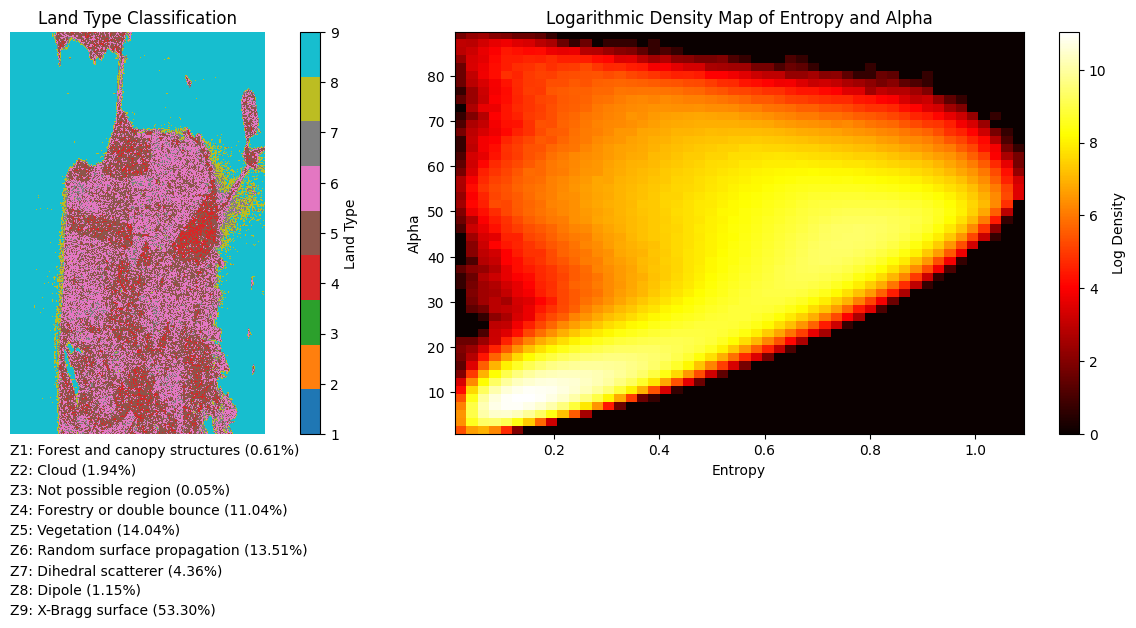

In [ ]:
# perform_and_plot_land_classification(entropy, alpha, Z)


/tmp/ipykernel_733953/3435662725.py:423: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 9)


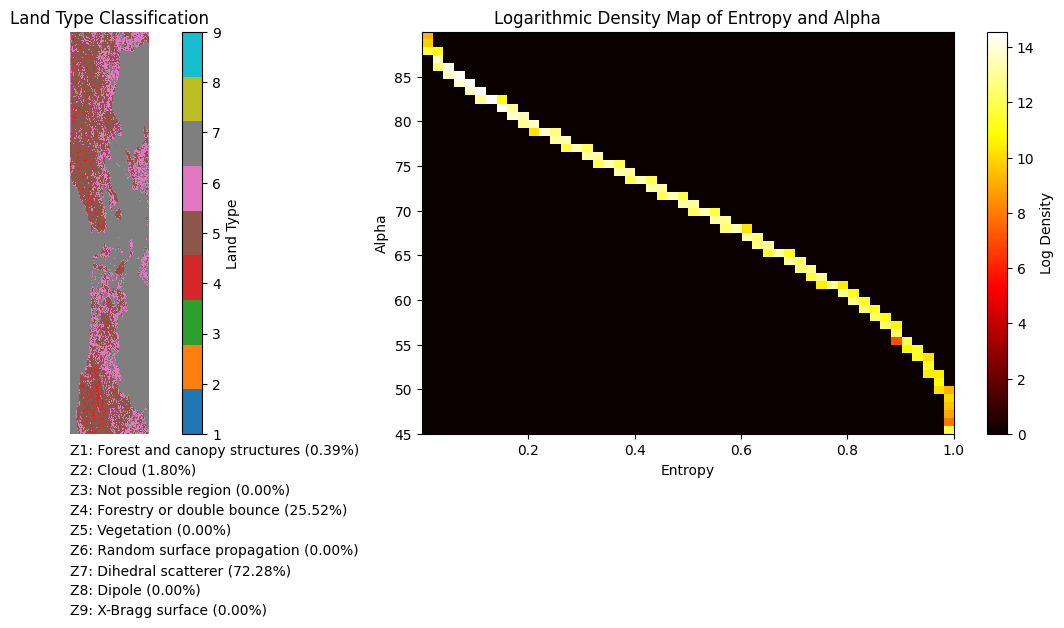

In [15]:
perform_and_plot_land_classification(entropy_simplify, alpha_simplify, Z_simplify)


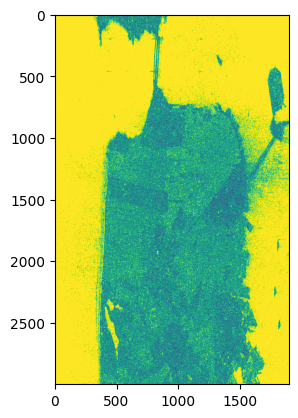

In [ ]:
# Compare entropy / alpha values with snap
base_dir = "/home/renaud/Data/polymetric_data/SAN_FRANCISCO_RS2/output"
snap_path = os.path.join(base_dir, "subset_0_SAN_FRANCISCO_RS2_landtype.tif")
data = tiff.imread(snap_path)
plt.imshow(data)